In [30]:
pd.read_csv("all data/citizen/kerala.csv")['Species_name'].value_counts()

Species_name
Mango (all varieties)-Mangifera indica          41613
Jackfruit-Artocarpus heterophyllus              39176
Coconut palm-Cocos nucifera                     14213
Tamarind-Tamarindus indica                      13992
Indian Laburnum-Cassia fistula                  12320
                                                ...  
Meethabhaji-Champereia manillana                    1
Chinar-Platanus Orientalis                          1
Himalayan Rhododendron-Rhododendron arboreum        1
Duabanga-Duabanga grandiflora                       1
Broken Bones Tree-Oroxylum Indicum                  1
Name: count, Length: 153, dtype: int64

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

df = pd.read_csv("all data/citizen/kerala.csv")

df = df[df["Species_name"] == "Tamarind-Tamarindus indica"]
#df = df[df["Species_name"] == "Mango (all varieties)-Mangifera indica"]
df = df[df["Year"] == 2023]
df = df.drop(["Date_of_observation", "Observation_ID", "User_id", "User_Tree_id", "Species_id", "State_name", "Species_name", "Year"], axis=1)
df = df.dropna()
df = df.reset_index(drop=True)

weeks = df["Week"]
df

,Lat,Long,Leaves_fresh,Leaves_mature,Leaves_old,Flowers_bud,Flowers_open,Flowers_male,Flowers_Female,Fruits_unripe,Fruits_ripe,Fruits_open,Week
0,10.77863,76.49467,2.0,2.0,2.0,2.0,2.0,-2.0,-2.0,2.0,2.0,-2.0,5
1,9.13646,76.62594,0.0,2.0,1.0,0.0,0.0,-2.0,-2.0,0.0,2.0,-2.0,48
2,11.83188,75.56551,1.0,2.0,0.0,2.0,1.0,-2.0,-2.0,1.0,2.0,-2.0,45
3,11.83188,75.56551,1.0,2.0,1.0,2.0,1.0,-2.0,-2.0,1.0,2.0,-2.0,46
4,11.83188,75.56551,1.0,2.0,1.0,2.0,1.0,-2.0,-2.0,1.0,2.0,-2.0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707,11.77262,75.48394,1.0,2.0,1.0,0.0,0.0,-2.0,-2.0,2.0,1.0,-2.0,36
1708,10.75795,76.51333,0.0,2.0,1.0,0.0,0.0,-2.0,-2.0,0.0,0.0,-2.0,10
1709,10.75795,76.51333,0.0,2.0,0.0,0.0,0.0,-2.0,-2.0,2.0,0.0,-2.0,37
1710,10.75795,76.51333,0.0,2.0,0.0,0.0,0.0,-2.0,-2.0,2.0,0.0,-2.0,36


In [42]:
data = {}

for week in weeks.unique():
    
    # CLUSTERING
    
    print(f"Week {week}")
    week_df = df[df["Week"] == week]
    
    week_df.drop("Week", axis=1)
    week_df = week_df.reset_index(drop=True)
    
    km = KMeans(n_clusters=1, random_state=42, n_init="auto")
    
    clusters = km.fit_predict(week_df)


    centroids = km.cluster_centers_

    distances = []

    for i, row in week_df.iterrows():
        cluster_label = clusters[i]
        centroid = centroids[0]
        relevant_values = row.values[:len(row.values)]
        float_centroid = [float(val) for val in centroid[:len(centroid)]]
        distance = np.linalg.norm(relevant_values[:len(relevant_values)] - float_centroid)
        distances.append(distance)
    
    #score = silhouette_score(week_df, clusters, metric='euclidean')
    #sil_score.append(score)
        
    #print("Silhouette score: ", score)
        
    # FILTERING
    
    week_df['Distance_to_Centroid'] = distances
    
    std_dev_dist = week_df['Distance_to_Centroid'].std()
    mean = np.mean(week_df["Distance_to_Centroid"])
    
    valid_data = week_df[(week_df['Distance_to_Centroid'] >= mean - 1*std_dev_dist) & (week_df['Distance_to_Centroid'] <= mean + 1*std_dev_dist)]
    
    valid_data = valid_data.reset_index(drop=True)
    clusters2 = km.fit_predict(valid_data)
    
    d = []
    
    centroids = km.cluster_centers_

    for i, row in valid_data.iterrows():
        cluster_label = clusters2[i]
        centroid = centroids[0]
        relevant_values = row.values
        float_centroid = [float(val) for val in centroid]
        distance = np.linalg.norm(relevant_values - float_centroid)
        d.append(distance)
    
    valid_data['Distance_to_Centroid'] = d
    closest_point = valid_data[ valid_data["Distance_to_Centroid"] == min(valid_data['Distance_to_Centroid']) ]
    print(f"Week {week} reference: {closest_point.iloc[0]}")
    
    data[week] = closest_point.iloc[0]
    

Week 5
Week 5 reference: Lat                     11.005920
Long                    76.018100
Leaves_fresh             2.000000
Leaves_mature            2.000000
Leaves_old               0.000000
Flowers_bud              1.000000
Flowers_open             1.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              1.000000
Fruits_open             -2.000000
Week                     5.000000
Distance_to_Centroid     1.572337
Name: 9, dtype: float64
Week 48
Week 48 reference: Lat                      9.293040
Long                    76.589120
Leaves_fresh             0.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            0.000000
Fruits_ripe              2.000000
Fruits_open             -2.000000
Week                    48.000000
Distan

Week 35 reference: Lat                      9.159450
Long                    76.607720
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              0.000000
Flowers_open             1.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              1.000000
Fruits_open             -2.000000
Week                    35.000000
Distance_to_Centroid     1.331147
Name: 6, dtype: float64
Week 36
Week 36 reference: Lat                     10.356400
Long                    76.127650
Leaves_fresh             1.000000
Leaves_mature            2.000000
Leaves_old               0.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            0.000000
Fruits_ripe              0.000000
Fruits_open             -2.000000
Week                    36.000000
Distance_to_

Week 11 reference: Lat                      8.812350
Long                    76.758870
Leaves_fresh             1.000000
Leaves_mature            1.000000
Leaves_old               2.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            0.000000
Fruits_ripe              0.000000
Fruits_open             -2.000000
Week                    11.000000
Distance_to_Centroid     1.309202
Name: 6, dtype: float64
Week 7
Week 7 reference: Lat                     10.771890
Long                    76.481930
Leaves_fresh             2.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              2.000000
Flowers_open             1.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            2.000000
Fruits_ripe              1.000000
Fruits_open             -2.000000
Week                     7.000000
Distance_to_Ce

In [43]:
time = np.arange(0, 49)
flowers_bud = []

for key, value in data.items():
    print(f"{key}: {value}")

#for i in range(49):
#    flowers_bud.append(data[i])
#    
#    print(f"Observations in week {i}: ", len(df[df["Week"] == i]))
#
#plt.plot(time, flowers_bud)
#plt.title("Flowers bud, 2023")
#plt.show()

5: Lat                     11.005920
Long                    76.018100
Leaves_fresh             2.000000
Leaves_mature            2.000000
Leaves_old               0.000000
Flowers_bud              1.000000
Flowers_open             1.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            1.000000
Fruits_ripe              1.000000
Fruits_open             -2.000000
Week                     5.000000
Distance_to_Centroid     1.572337
Name: 9, dtype: float64
48: Lat                      9.293040
Long                    76.589120
Leaves_fresh             0.000000
Leaves_mature            2.000000
Leaves_old               1.000000
Flowers_bud              0.000000
Flowers_open             0.000000
Flowers_male            -2.000000
Flowers_Female          -2.000000
Fruits_unripe            0.000000
Fruits_ripe              2.000000
Fruits_open             -2.000000
Week                    48.000000
Distance_to_Centroid     1.537966
Name: 8, dtype: f

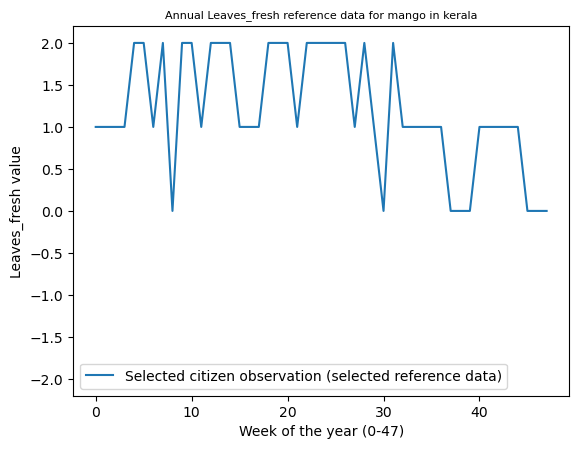

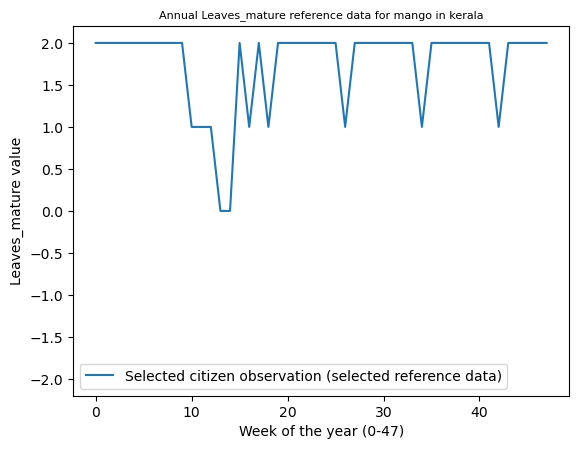

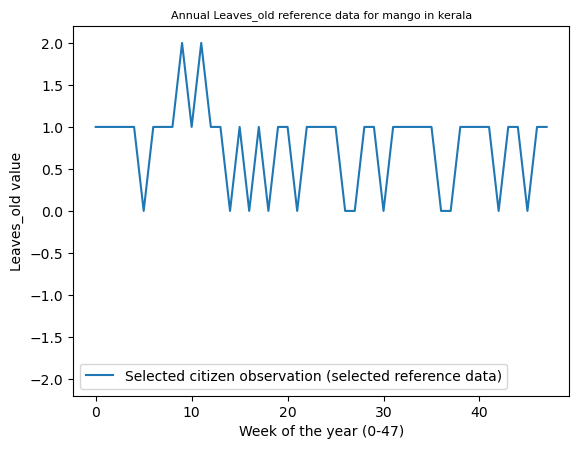

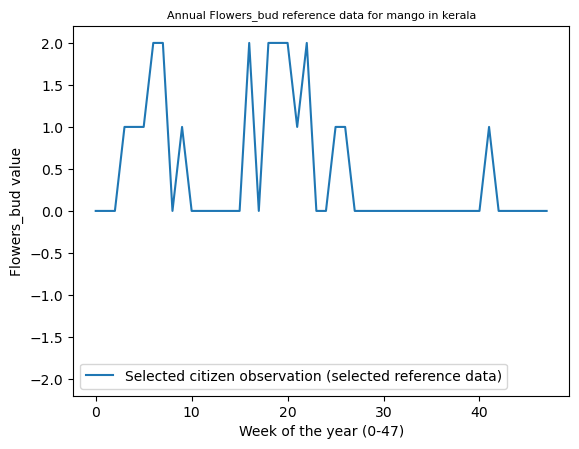

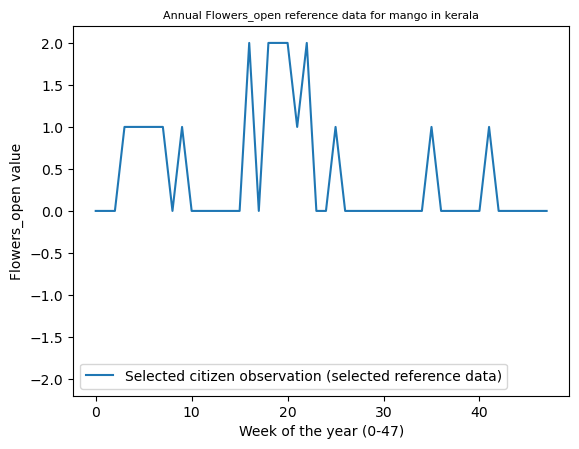

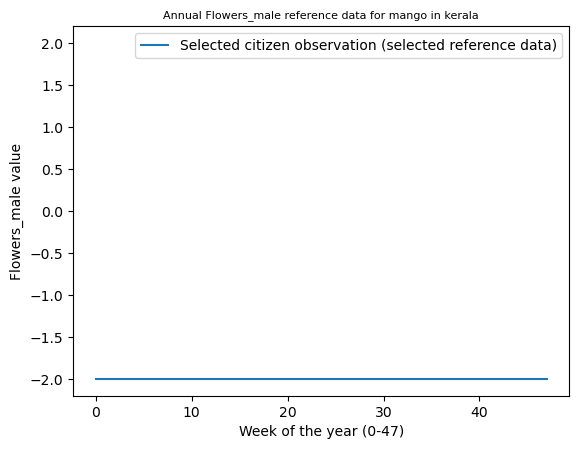

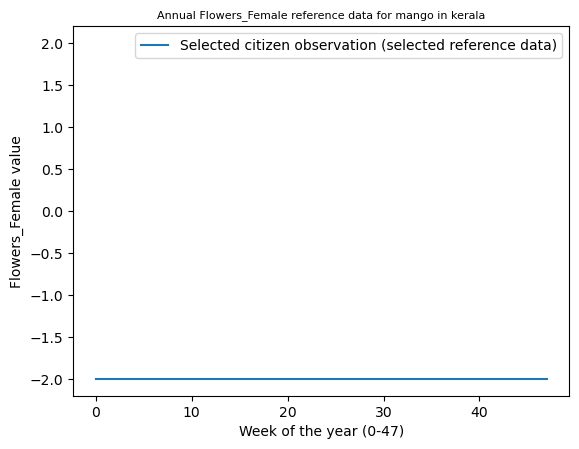

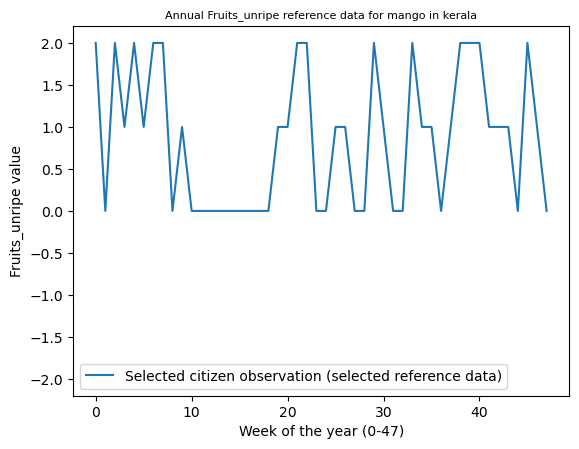

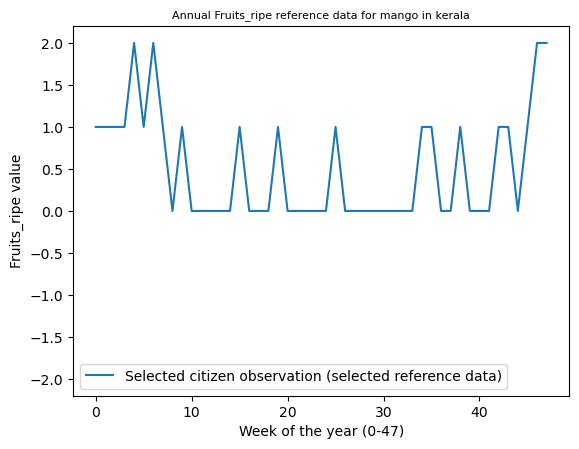

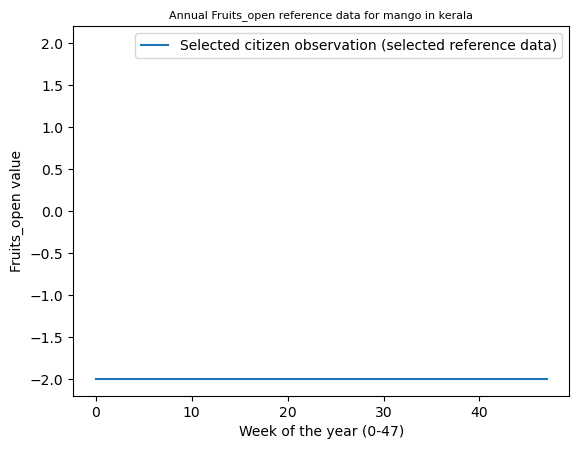

In [44]:
#os.makedirs(f"{plot_path}/{state}", exist_ok=True)

phenophases = ['Leaves_fresh','Leaves_mature','Leaves_old','Flowers_bud','Flowers_open',
               'Flowers_male','Flowers_Female','Fruits_unripe','Fruits_ripe','Fruits_open']
for phenophase in phenophases:
    #os.makedirs(f"{plot_path}/{state}", exist_ok=True)
    x = list(range(48))
    y = [data[week][phenophase] for week in range(48)]

    plt.plot(x, y, label=f'Selected citizen observation (selected reference data)')
    plt.xlabel('Week of the year (0-47)')
    plt.ylabel(f'{phenophase} value')
    plt.ylim(-2.2,2.2)
    #plt.title(f'Annual {phenophase} reference data for {species} in {state}', fontsize=8)
    plt.title(f'Annual {phenophase} reference data for mango in kerala', fontsize=8)
    plt.legend()
    plt.show()
    #plt.savefig(f"{plot_path}/{state}/{species.replace(' ', '').replace('.', '').lower()}_{transition_attr}_{year}")
    #plt.close()

In [ ]:
ref_dfs = {}
for filename in os.listdir("all data/reference"):
    ref_dfs[filename.rstrip('.csv')] = pd.read_csv("all data/reference/{}".format(filename)) # !!! CHANGE THIS !!!
for state in ref_dfs:
    state_ref_df = ref_dfs[state]
    for species in state_ref_df['species_name'].unique():
        species_ref_df = state_ref_df[state_ref_df['species_name'] == species]
        
        os.makedirs(f"{plot_path}/{state}", exist_ok=True)
        
        phenophases = ['Leaves_fresh','Leaves_mature','Leaves_old','Flowers_bud','Flowers_open',
                       'Flowers_male','Flowers_Female','Fruits_unripe','Fruits_ripe','Fruits_open']
        for phenophase in phenophases:
            x = list(range(48))
            y = species_ref_df[phenophase]
            
            plt.plot(x, y, label=f'Selected citizen observation (selected reference data)')
            plt.xlabel('Week of the year (0-47)')
            plt.ylabel(f'{phenophase} value')
            plt.title(f'Annual {phenophase} reference data for {species} in {state}', fontsize=8)
            plt.legend()
            plt.show()
            #plt.savefig(f"{plot_path}/{state}/{species.replace(' ', '').replace('.', '').lower()}_{transition_attr}_{year}")
            #plt.close()